When benchmarking you **MUST**

1. close all applications
2. close docker
3. close all but this Web windows
4. all pen editors other than jupyter-lab (this notebook)


In [1]:
import os
from cloudmesh.common.Shell import Shell
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pandas as pd
from tqdm.notebook import tqdm
from cloudmesh.common.util import readfile
from cloudmesh.common.util import writefile
from cloudmesh.common.StopWatch import StopWatch 

sns.set_theme(style="whitegrid")

In [2]:
user = "gregor"
node = "mac"

processors = 4
experiments = 10
maximum = 1024 * 100000
intervals = 10

In [3]:
label = f"{user}-{node}"

delta = int(maximum / intervals)

totals = [64] + list(range(0,maximum, delta))[1:]
points = [int(t/processors) for t in totals]
print (totals)
print(points)

[64, 10240000, 20480000, 30720000, 40960000, 51200000, 61440000, 71680000, 81920000, 92160000]
[16, 2560000, 5120000, 7680000, 10240000, 12800000, 15360000, 17920000, 20480000, 23040000]


In [4]:

systeminfo = StopWatch.systeminfo()
writefile(f"benchmark/{label}-sysinfo.log", systeminfo)
print (systeminfo)

+------------------+--------------------------------------------------------------------------------------------------+
| Attribute        | Value                                                                                            |
|------------------+--------------------------------------------------------------------------------------------------|
| cpu              | Intel(R) Core(TM) i7-7920HQ CPU @ 3.10GHz                                                        |
| cpu_count        | 8                                                                                                |
| frequency        | scpufreq(current=3100, min=3100, max=3100)                                                       |
| mem.active       | 5.6 GiB                                                                                          |
| mem.available    | 6.2 GiB                                                                                          |
| mem.free         | 508.4 MiB          

In [5]:
df = pd.DataFrame(
{"Size": points}
)
df = df.set_index('Size')

In [6]:
os.makedirs("benchmark", exist_ok=True)

experiment_progress = tqdm(range(0, experiments), desc ="Experiment")

experiment = -1
for experiment in experiment_progress:
    exoeriment = experiment + 1

    label="gregor-mac"
    log = f"benchmark/result-{label}-{experiment}.log"
    os.system(f"rm {log}")


    name = points[experiment]
    progress = tqdm(range(0, len(points)), 
                    desc =f"Benchmark {name}",
                    bar_format="{desc:<30} {total_fmt} {r_bar}")
    
    i = -1
    for state in progress:
        i = i + 1
        n = points[i]
        command = f"mpiexec -n {processors} python count-click.py " + \
                  f"--n {n} --max_number 10 --find 8 --label {label} " + \
                  f"--user {user} --node={node} " + \
                  f"| tee -a {log}"
        os.system (command)

    content = readfile(log).splitlines()
    lines = Shell.cm_grep(content, "csv,Result:")
    # print(lines)
    values = []
    times = []

    for line in lines:
        msg = line.split(",")[7]
        t = line.split(",")[4]

        total, overall, trials, find, label = msg.split(" ")
        values.append(int(overall))
        times.append(float(t))
        # print (t, overall)


    #data = pd.DataFrame(values, times, columns=["Values", "Time"])

    #print (data.describe())
    #sns.lineplot(data=data, palette="tab10", linewidth=2.5)
    # df["Size"] = values
    df[f"Time_{experiment}"] = times
    # print(df)


Experiment:   0%|          | 0/10 [00:00<?, ?it/s]

Benchmark 16                   10 | 0/10 [00:00<?, ?it/s]

Benchmark 2560000              10 | 0/10 [00:00<?, ?it/s]

Benchmark 5120000              10 | 0/10 [00:00<?, ?it/s]

Benchmark 7680000              10 | 0/10 [00:00<?, ?it/s]

Benchmark 10240000             10 | 0/10 [00:00<?, ?it/s]

Benchmark 12800000             10 | 0/10 [00:00<?, ?it/s]

Benchmark 15360000             10 | 0/10 [00:00<?, ?it/s]

Benchmark 17920000             10 | 0/10 [00:00<?, ?it/s]

Benchmark 20480000             10 | 0/10 [00:00<?, ?it/s]

Benchmark 23040000             10 | 0/10 [00:00<?, ?it/s]

In [7]:

df = df.rename_axis(columns="Time")
df
    

Time,Time_0,Time_1,Time_2,Time_3,Time_4,Time_5,Time_6,Time_7,Time_8,Time_9
Size,,,,,,,,,,
16,0.001,0.000,0.000,0.008,0.004,0.001,0.003,0.002,0.000,0.000
2560000,2.523,2.708,2.742,2.739,2.805,2.729,2.749,2.859,2.769,2.742
5120000,5.275,5.608,5.677,5.823,5.733,5.649,5.707,5.726,5.712,5.702
7680000,8.435,8.579,9.204,8.768,8.551,8.701,8.554,8.552,8.671,8.720
10240000,11.311,11.377,11.451,11.519,11.820,13.657,11.496,11.794,11.461,11.492
12800000,13.644,14.164,14.350,14.367,14.453,14.428,14.363,14.368,14.838,14.424
15360000,16.877,16.958,17.188,17.575,17.202,17.217,17.288,17.966,18.030,17.560
17920000,19.694,20.117,20.141,20.420,20.148,20.011,20.353,20.113,19.998,20.402
20480000,22.603,22.881,22.900,22.899,22.946,22.954,24.037,22.950,23.468,23.125


<AxesSubplot:xlabel='Size'>

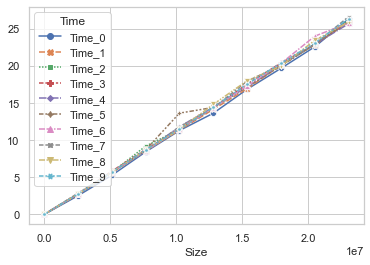

In [8]:
sns.lineplot(data=df, markers=True)

In [9]:
plt.show()

In [10]:
plt.savefig(f'benchmark/benchmark-{label}.png')

<Figure size 432x288 with 0 Axes>

In [11]:
plt.savefig(f'benchmark/benchmark-{label}.pdf')

<Figure size 432x288 with 0 Axes>

In [12]:
plt.show()

In [13]:
dfs = df.stack().reset_index()
dfs = dfs.set_index('Size')
dfs = dfs.drop(columns=['Time'])
dfs = dfs.rename(columns={0:'Time'})
dfs

,Time
Size,
16,0.001
16,0.000
16,0.000
16,0.008
16,0.004
...,...
23040000,25.946
23040000,25.811
23040000,26.659


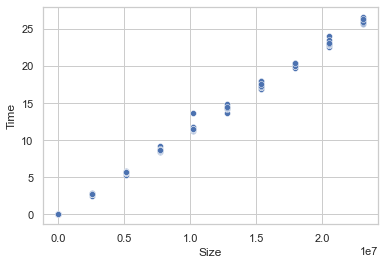

In [18]:
sns.scatterplot(data=dfs, x="Size", y="Time");
plt.savefig(f"benchmark/benchmark-{label}-scatter.pdf")

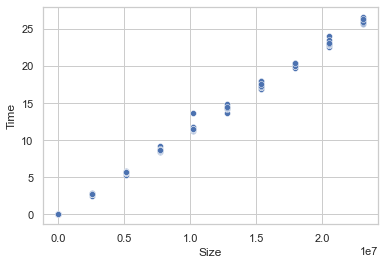

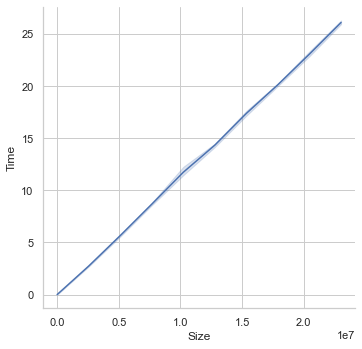

In [14]:
sns.relplot(x="Size", y="Time", kind="line", data=dfs);
plt.savefig(f"benchmark/benchmark-{label}-line.pdf")

In [ ]:
plt.save

In [15]:
df.to_pickle(f"benchmark/{label}-df.pkl")